# Import libraries

In [2]:
import pathlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Read data from file

In [3]:
df = pd.read_csv('../data/raw/data.csv',parse_dates=True, header=None)

# Looking into data

In [4]:
df.head()

,0,1
0,2021-01-04 09:15:00,1975
1,2021-01-04 10:15:00,1972
2,2021-01-04 11:15:00,1973
3,2021-01-04 12:15:00,1976
4,2021-01-04 13:15:00,1987


In [5]:
df.columns = ['Datetime','Close']

In [6]:
df.describe()

,Close
count,3454.000000
mean,2365.237406
std,243.880128
min,1837.000000
25%,2134.500000
50%,2414.000000
75%,2566.000000
max,2847.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Datetime  3454 non-null   object
 1   Close     3454 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.1+ KB


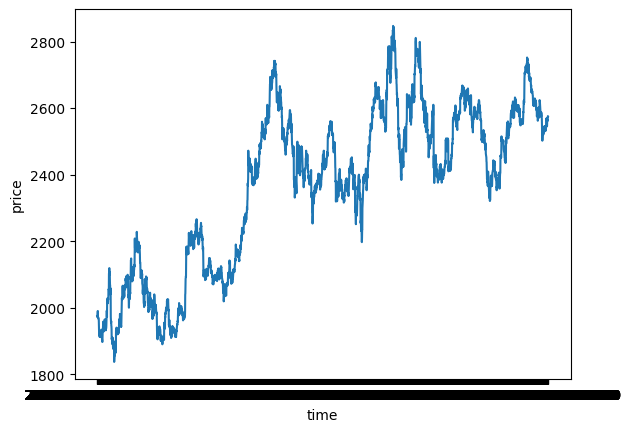

In [8]:
plt.plot(df["Datetime"], df["Close"])
plt.xlabel("time")
plt.ylabel("price")
plt.show()

# Find p, d, and q values for ARIMA model 

Before building the ARIMA model, let’s see if there is some cross-correlation in out data.

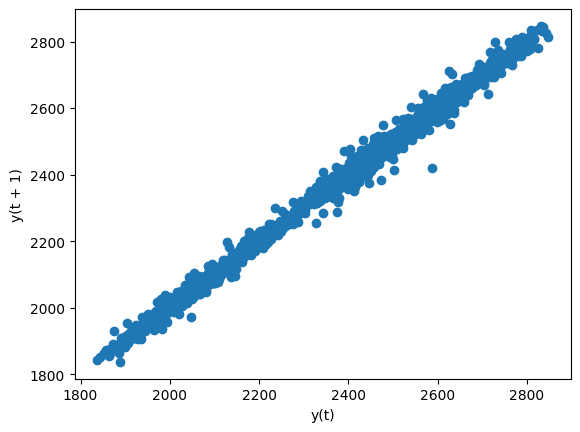

In [9]:
lag_plot(df['Close'], lag=1)
plt.show()

p is order of Autoregrassion <br>
d is order of differencing requiredd to make time series stationary <br>
q is order Moving aaverages

## Stationarity

Substract current value from previous value. We need to do diffenting peration multiple times to make series stationary. <br>
Select minimun value for ARIMA model.

### ADF test

We will use Augumented Dickey Fuller (ADF) test check stationarity in series. <br>
<br>
Null hypothesis of ADF test is that time series is non-stationary. If p-value of test is less than 0.05 then wee can reject null hypothesis. <br>
So, if p-value > 0.05 we'll find order of diffencing.  

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
dftest = adfuller(df['Close'],autolag='AIC')
print('1. ADF statistic :',dftest[0])
print('2. P-value :',dftest[1])

1. ADF statistic : -2.1451436455002684
2. P-value : 0.2267536052590433


## ## We find our series is non-stationary.

In [12]:
# from pmdarima import auto_arima
# import warnings
# warnings.filterwarnings('ignore')

## Autocorrelation Function (ACF) Plot

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

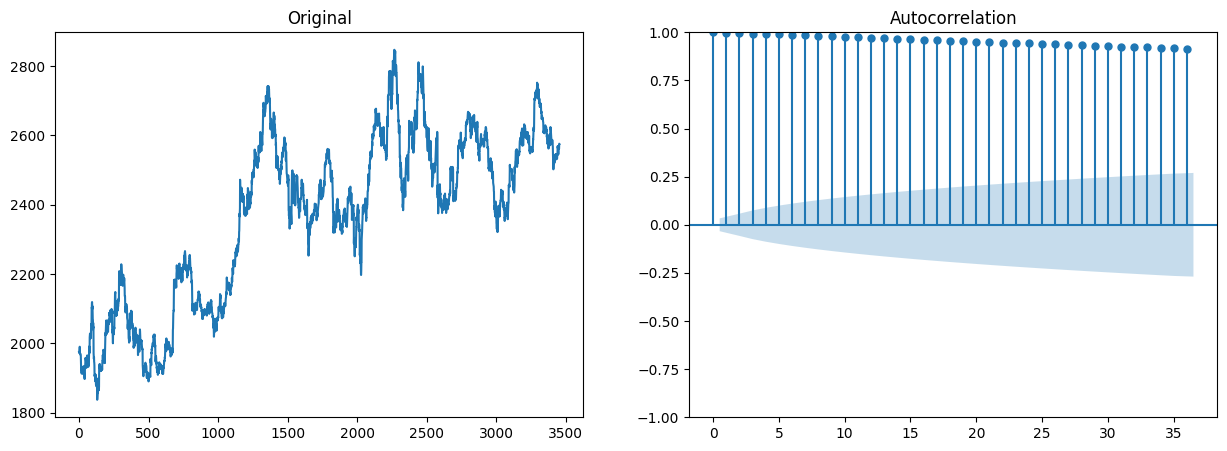

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(df['Close'])
ax1.set_title('Original')
plot_acf(df['Close'], ax=ax2);

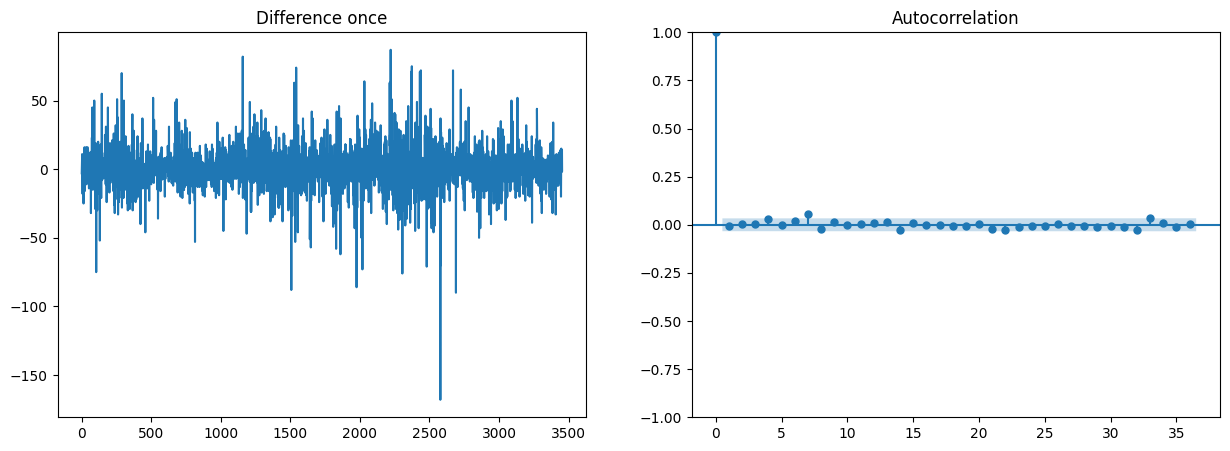

In [15]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

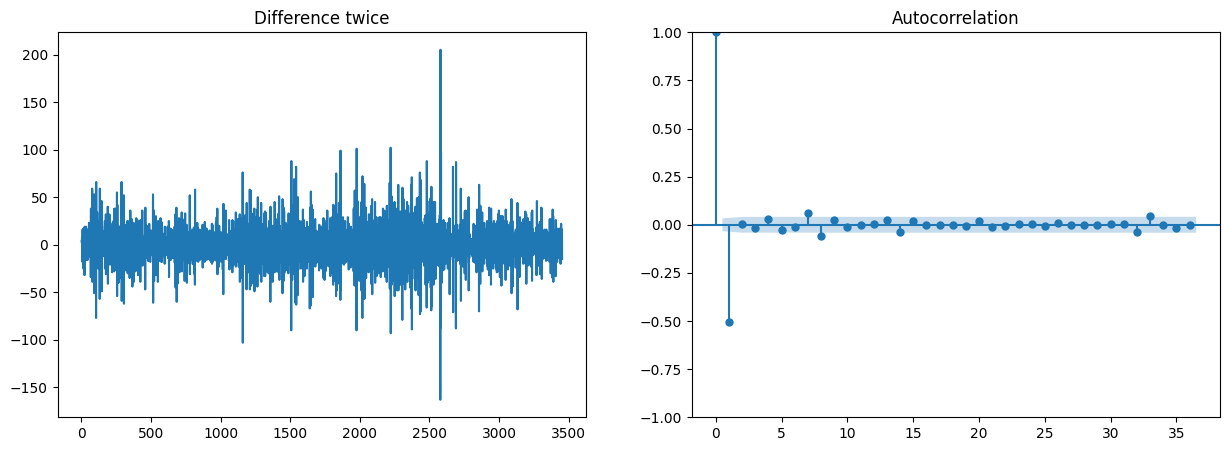

In [16]:
diff = df['Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

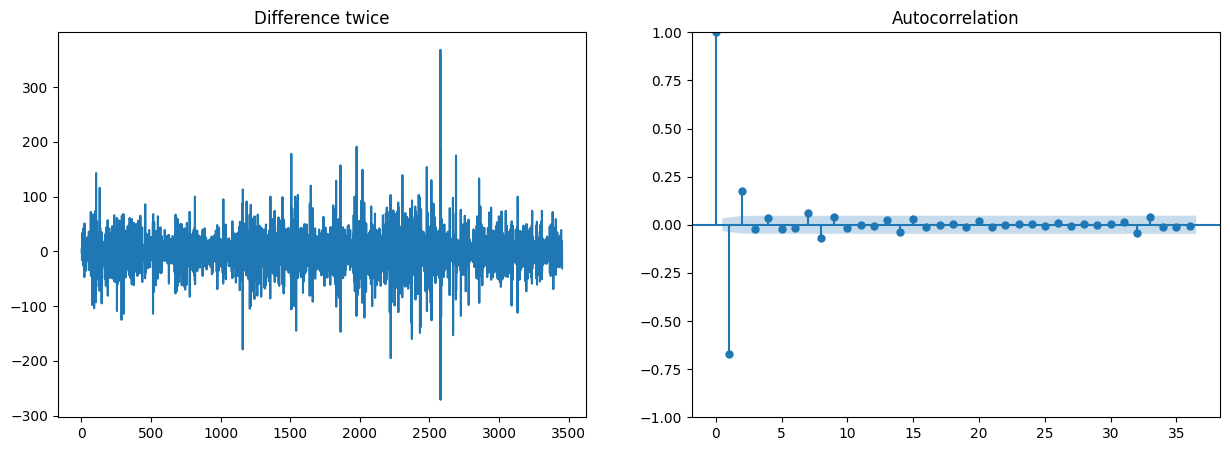

In [17]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

## ## Here we find diffence order 3 is good.

Because there is gives positive value in third order differencing.

# p

p is the order of Auto regression (AR). It refers to number of lags to be used ass predictors. <br>
We can find required number of AR terms by inspecting Partial Autocorrelation (PACF) plot. <br>
The Partial Autocorrelation represents correlation between series and it's lags.

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

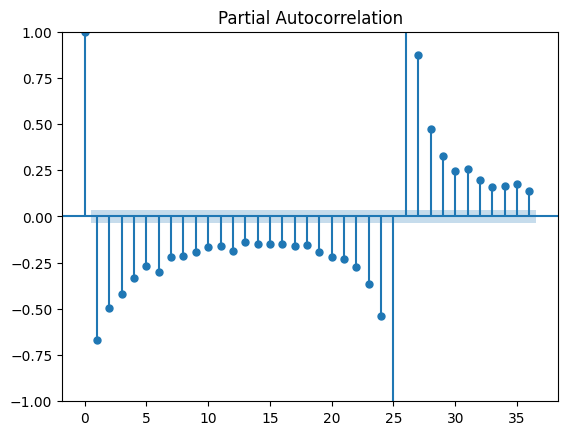

In [38]:
diff = df['Close'].diff().diff().diff().dropna()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# ax1.plot(diff)
# ax1.set_title('Difference once')
p = plot_pacf(diff);

In [20]:
# statsmodels.tsa.stattools.pacf
from statsmodels.tsa.stattools import pacf
diff = df['Close'].diff().diff().diff().dropna()
print(pacf(diff))

[ 1.         -0.66984903 -0.49367684 -0.42139803 -0.33118764 -0.26651598
 -0.30123047 -0.2208019  -0.21386271 -0.19204196 -0.16760732 -0.161067
 -0.18730453 -0.13985752 -0.15149306 -0.14916869 -0.15081782 -0.16100469
 -0.15406411 -0.1918776  -0.21678696 -0.22793113 -0.27556309 -0.36377816
 -0.5393254  -1.17095419  6.77030161  0.87268047  0.47337661  0.32746174
  0.24798922  0.25890654  0.19900697  0.15896793  0.16714133  0.17783797]


In [21]:
from statsmodels.tsa.stattools import acf
diff = df['Close'].diff().diff().diff().dropna()
print(acf(diff))

[ 1.00000000e+00 -6.69654932e-01  1.76430259e-01 -2.16177378e-02
  3.32384296e-02 -2.30348943e-02 -1.86598742e-02  6.22573609e-02
 -6.70428551e-02  4.00472689e-02 -1.42636226e-02  1.03078124e-03
 -5.57934998e-03  2.67006149e-02 -3.92836313e-02  2.76770847e-02
 -9.32578075e-03  7.30990175e-04  3.40172826e-03 -1.27168084e-02
  2.13762252e-02 -1.35701950e-02 -2.62980338e-03  5.08995510e-03
  2.49377163e-03 -7.98005182e-03  9.15517710e-03 -5.58841573e-03
  2.34265601e-03 -3.50656029e-03  2.88938637e-03  1.36086759e-02
 -4.12387112e-02  4.22332327e-02 -9.47205641e-03 -1.02866146e-02]


/home/rohit/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


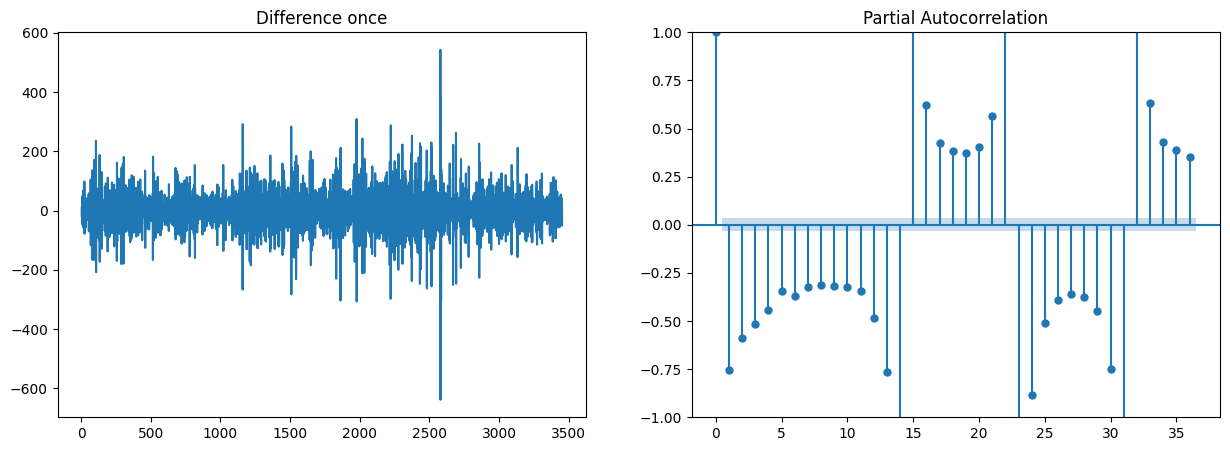

In [46]:
diff = df['Close'].diff().diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_pacf(diff, ax=ax2);

## ## 20 is the positive value for Auto regression

# q

q is the order of moving average (MA). It refers to number of laged forecast erros that should be go into the ARIMA. <br>
We can look at ACF plot for number of MA term.

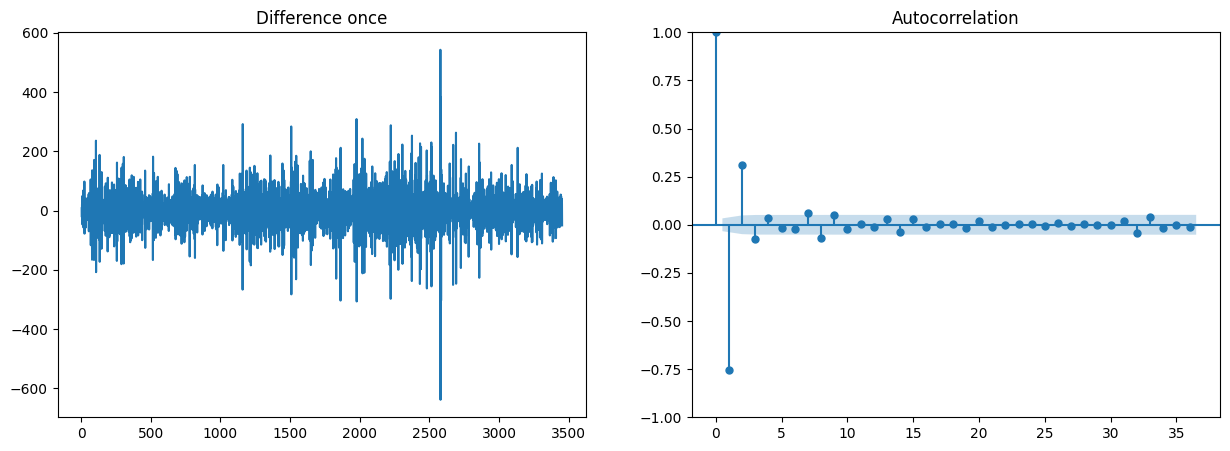

In [47]:
diff = df['Close'].diff().diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

## ## We find that 2 is no order for MA

In [24]:
# stepswise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True)
# stepswise_fit.summary()

# Let's build model

In [25]:
# train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]

# training_data = train_data['Close'].values
# test_data = test_data['Close'].values

# history = [x for x in training_data]
# model_predictions = []
# N_test_observations = len(test_data)

# residuals = 0

# for time_point in range(N_test_observations):
#     model = ARIMA(history, order=(20,3,2))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     model_predictions.append(yhat)
#     true_test_value = test_data[time_point]
#     history.append(true_test_value)

#     residuals = pd.DataFrame(model_fit.resid)
    
# MSE_error = mean_squared_error(test_data, model_predictions)
# print('Testing Mean Squared Error is {}'.format(MSE_error))

In [26]:
# residuals = residuals[1:]

In [27]:
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

In [28]:
# test_set_range = df[int(len(df)*0.7):]
# plt.plot(test_set_range.index, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
# plt.plot(test_set_range.index, test_data, color='red', label='Actual Price')
# plt.title('Infosys Prices Prediction')
# plt.xlabel('Date')
# plt.ylabel('Prices')
# plt.legend()
# plt.show()

In [29]:
df.tail(10)

,Datetime,Close
3444,2022-12-30 13:15:00,2565
3445,2022-12-30 14:15:00,2545
3446,2022-12-30 15:15:00,2547
3447,2023-01-02 09:15:00,2562
3448,2023-01-02 10:15:00,2563
3449,2023-01-02 11:15:00,2563
3450,2023-01-02 12:15:00,2564
3451,2023-01-02 13:15:00,2562
3452,2023-01-02 14:15:00,2576
3453,2023-01-02 15:15:00,2575


In [55]:
history = [x for x in df['Close'].values]

modelF = ARIMA(history, order=(26,3,2))
model_Fit = modelF.fit()

In [56]:
future_index = pd.date_range(start='2022-11-18 09:30:00', end='2022-11-18 15:30:00', freq='1H')

In [57]:
future_index[:10]

DatetimeIndex(['2022-11-18 09:30:00', '2022-11-18 10:30:00',
               '2022-11-18 11:30:00', '2022-11-18 12:30:00',
               '2022-11-18 13:30:00', '2022-11-18 14:30:00',
               '2022-11-18 15:30:00'],
              dtype='datetime64[ns]', freq='H')

In [58]:
print(len(future_index))

7


In [59]:
output = model_Fit.forecast(steps=7)

In [60]:
output

array([2577.15606594, 2578.39525653, 2580.87219884, 2581.96010734,
       2583.32625   , 2586.2725805 , 2587.21759569])

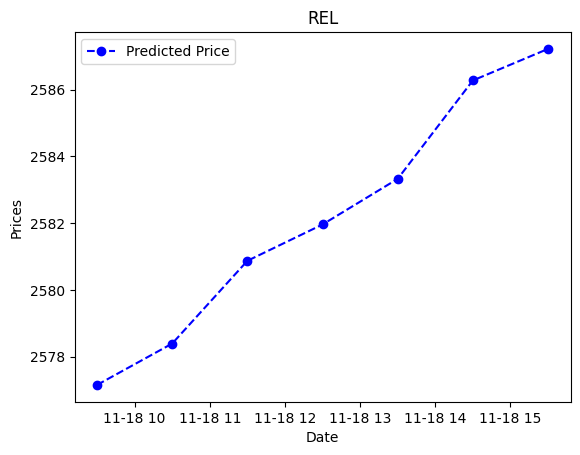

In [61]:
plt.plot(future_index, output, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.title('REL')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()